In [14]:
import librosa
import numpy as np
from numpy.fft import rfft
from numpy import pi
from matplotlib import pyplot as plt
from IPython.display import Audio
import cmath
import scipy
from cache_no_hash import cache
from blindDescend import blindDescend
from yin import yin
from harmonicSynth import HarmonicSynth, Harmonic

TWO_PI = np.pi * 2

In [15]:
PAGE_LEN = 1024
SR = 22050
DTYPE = np.float32
N_HARMONICS = 8

In [16]:
HANN = scipy.signal.get_window('hann', PAGE_LEN, True)
IMAGINARY_LADDER = np.linspace(0, TWO_PI * 1j, PAGE_LEN)
SPECTRUM_SIZE = PAGE_LEN // 2 + 1
NYQUIST = SR // 2

In [17]:
def sino(freq, length):
    return np.sin(np.arange(length) * freq * TWO_PI / SR)

def playHard(data):
    return Audio(data, rate = SR)
def play(data, soft = .1):
    t = np.concatenate([data, [1]])
    length = round(soft * SR)
    t[:length ] = np.multiply(t[:length ], np.linspace(0, 1, length))
    t[-length:] = np.multiply(t[-length:], np.linspace(1, 0, length))
    return playHard(t)

def findPeaks(energy):
    slope = np.sign(energy[1:] - energy[:-1])
    extrema = slope[1:] - slope[:-1]
    return np.argpartition(
        (extrema == -2) * energy[1:-1], - N_HARMONICS,
    )[- N_HARMONICS:] + 1

def sft(signal, freq_bin):
    # Slow Fourier Transform
    return np.abs(np.sum(signal * np.exp(IMAGINARY_LADDER * freq_bin))) / PAGE_LEN

def refineGuess(guess, signal):
    def loss(x):
        if x < 0:
            return 0
        return - sft(signal, x)
    freq_bin, loss = blindDescend(loss, .01, .4, guess)
    return freq_bin * SR / PAGE_LEN, - loss

def widePlot(h = 3, w = 12):
    plt.gcf().set_size_inches(w, h)

    
def spectro(signal, do_wide = True, trim = 130):
    energy = np.abs(rfft(signal * HANN))
    plt.plot(energy[:trim])
    if do_wide:
        widePlot()

def concatSynth(synth, harmonics, n):
    buffer = []
    for i in range(n):
        synth.eat(harmonics)
        buffer.append(synth.mix())
    return np.concatenate(buffer)

def pitch2freq(pitch):
    return np.exp((pitch + 36.37631656229591) * 0.0577622650466621)

def freq2pitch(f):
    return np.log(f) * 17.312340490667562 - 36.37631656229591

def pagesOf(signal):
    for i in range(0, signal.size - PAGE_LEN + 1, PAGE_LEN):
        yield signal[i : i + PAGE_LEN]


In [18]:
from time import sleep
import mido

In [19]:
mido.get_output_names()

['CASIO USB-MIDI 2', 'Microsoft GS Wavetable Synth 0', 'VirtualMIDISynth #1 1']

In [20]:
port = mido.open_output(
    'CASIO USB-MIDI 2', 
)
port

SystemError: MidiOutWinMM::openPort: error creating Windows MM MIDI output port.

In [21]:
port.send(mido.Message('note_on', note=60))

In [22]:
# port.send(mido.Message('note_off', note=60))
port.panic()

In [23]:
v = [64] * 50
v[2] = 32  # C5
v[3] = 30  # G5
v[4] = 64  # C6
v[5] = 64  # E6
A = 6
B = 15
C = 10
for i in range(A, B):
    v[i] = round(64 - (64 - C) / (B - A) * (i - A))
for i in range(B, 50):
    v[i] = C
print(v)
def oneNote(pitch):
    port.panic()
    msgs = []
    for i in range(2, 40):
#     for i in range(39, 1, -1):
#     for i in range(2, 7):
#     for i in range(6, 1, -1):
        delta = np.log(i) * 17.312340490667562
        d = round(delta)
        if pitch + d > 127:
            continue
        err = delta - d
#         print(f'{round(err * 100)}%')
        _v = round((.5 - abs(err)) * 2 * v[i])
        msgs.append(mido.Message(
            'note_on', note=pitch + d, 
#             velocity=min(127, round(
#                 100/max(1, (i+3))
#             )), 
#             velocity=64, 
            velocity=_v, 
        ))
    [port.send(m) for m in msgs]

port.panic()
oneNote(60)

[64, 64, 32, 30, 64, 64, 64, 58, 52, 46, 40, 34, 28, 22, 16, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


In [24]:
hb = [
    0, 0, 2, None, 0, None, 5, None, 4, None, None, None, 
    0, 0, 2, None, 0, None, 7, None, 5, None, None, None, 
    0, 0, 12, None, 9, None, 5, None, 4, None, 2, None, 
    10, 10, 9, None, 5, None, 7, None, 5, None, None, None,     
]

In [25]:
def playSong(song, interval = .2, middle = 55, func = oneNote):
    for note in song:
        if note is not None:
            func(note + middle)
        sleep(interval)
    port.panic()

In [26]:
port.panic()

In [ ]:
playSong(hb)

In [27]:
# from mido import Message, MidiFile, MidiTrack
# mid = MidiFile()
# track = MidiTrack()
# mid.tracks.append(track)

# track.append(Message('program_change', program=12, time=0))
# track.append(Message('note_on', note=64, velocity=64, time=32))
# track.append(Message('note_off', note=64, velocity=127, time=64))

# mid.save('new_song.mid')

## math

In [28]:
from scipy.optimize import minimize
import numpy as np
from matplotlib import pyplot as plt

In [29]:
def getBins(x, N):
    bins = np.zeros((N, ))
    for i, e in enumerate(x):
        n = i + 2
        for j in range(n, N, n):
            bins[j] += e
    return bins
def loss(x, N):
    bins = getBins(x, N)[2:]
    if 0 in bins:
        return np.inf
    return np.sum(np.square(np.log(bins)))

In [30]:
def optim(N, n_seeds = 100):
    results = []
    for i in range(n_seeds):
        result = minimize(loss, np.random.rand(N - 2), (N, ), bounds = [(0, None)] * (N - 2))
        results.append((result.fun, result.x))
    results = sorted(results, key=lambda x:x[0])[:round(.1 * n_seeds)]
    for y, x in results:
        plt.plot(x)
    widePlot()
    plt.show()
    return results

In [31]:
from prime import getPrimesFrom3

In [32]:
getPrimesFrom3(15)

array([ 3,  5,  7, 11, 13], dtype=int64)

In [33]:
def present(results, N):
    print('y', results[0][0])
    print('x')
    print(results[0][1])
    for prime in [2, *getPrimesFrom3(N)]:
        plt.axvline(prime, c='r')
    plt.plot([0, 0, *results[0][1]])
    plt.plot(getBins(results[0][1], N))
    widePlot()

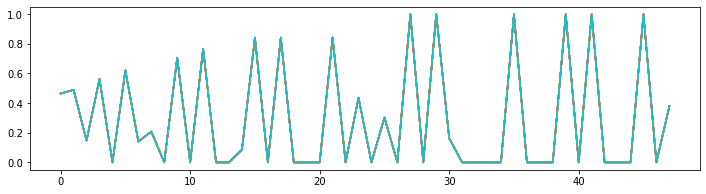

y 3.7236944296551124
x
[0.46377847 0.48950084 0.14706075 0.56313654 0.         0.62063295
 0.14005806 0.20767712 0.         0.70616005 0.         0.76555907
 0.         0.         0.08590234 0.84195949 0.         0.84196824
 0.         0.         0.         0.84196442 0.         0.43685713
 0.         0.30281865 0.         0.99998614 0.         0.99998979
 0.16321343 0.         0.         0.         0.         0.99999403
 0.         0.         0.         1.00000896 0.         0.99999309
 0.         0.         0.         0.9999938  0.         0.37935247]
50 loss 3.7236944296551124


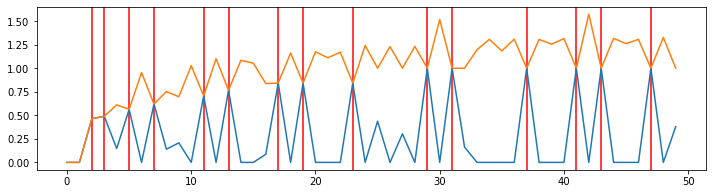

In [35]:
N=50
results_50 = optim(N)
present(results_50, N)
print('50 loss', loss(results_50[0][1], N))

In [34]:
N=100
results_100 = optim(N)
present(results_100, N)
print('50 loss', loss(results_100[0][1], 50))

KeyboardInterrupt: 

In [36]:
golden = results_50[0][1]
golden.size

48

In [89]:
import random
def oneGoldenNote(pitch, velocity = 64, N = 50):
    port.panic()
    msgs = []
#     for i in reversed(range(2, N)):
    for i in range(2, N):
        delta = np.log(i) * 17.312340490667562
        d = round(delta)
        if pitch + d > 127:
            continue
        err = delta - d
        freq_err_adj = np.exp(- abs(err) * 7)
        if pitch + d > 95:
            freq_err_adj *= .2
#         sub_energy = golden[i - 2] * velocity ** 2
#         adj_velocity = round((sub_energy * freq_err_adj) ** .5)
        sub_energy = golden[i - 2] * velocity
        adj_velocity = round((sub_energy * freq_err_adj))
        msgs.append(mido.Message(
            'note_on', note=pitch + d, velocity=adj_velocity, 
        ))
    random.shuffle(msgs)
    [port.send(m) for m in msgs]

port.panic()
oneGoldenNote(48)

In [40]:
port.panic()

In [92]:
playSong(hb, interval = .15, middle = 48, func = oneGoldenNote)